In [2]:
import tensorflow as tf
try: #If running in colab 
    import google.colab
    IN_COLAB = True 
except:
    IN_COLAB = False
if (not tf.__version__.startswith('2')): #Checking if tf 2.0 is installed
    if IN_COLAB: #If running in colab install tf 2.0
        !pip install tensorflow-gpu==2.0.0-alpha0
        !pip install pip install tfp-nightly==0.7.0-dev20190511
    print('Please install tensorflow 2.0 to run this notebook')
print('Tensorflow version: ',tf.__version__, ' running in colab?: ', IN_COLAB)

Tensorflow version:  2.0.0-alpha0  running in colab?:  True


In [149]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
import tensorflow_probability as tfp


%matplotlib inline
plt.style.use('default')

tfd = tfp.distributions
tfb = tfp.bijectors
print("TFP Version", tfp.__version__)
print("TF  Version",tf.__version__)
np.random.seed(42)
tf.random.set_seed(42)


TFP Version 0.7.0
TF  Version 2.0.0-alpha0


In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

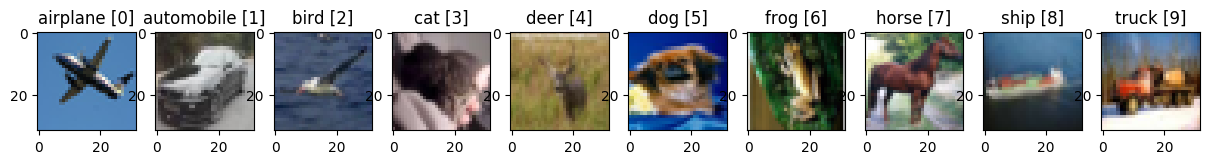

In [154]:
labels=np.array(["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"])
#sample image of each label
plt.figure(figsize=(20,20))
for i in range(0,len(np.unique(y_train))):
    rmd=np.random.choice(np.where(y_train==i)[0],1)
    plt.subplot(1,10,i+1)
    img=x_train[rmd]
    plt.imshow(img[0,:,:,:])
    plt.title(labels[i]+" "+np.str(y_train[rmd][0]))

In [0]:
#we delete all horses of the dataset
y_train_no_horse=np.delete(y_train,np.where(y_train==7)[0])
x_train_no_horse=np.delete(x_train,np.where(y_train==7)[0],axis=0)

In [156]:
print(y_train_no_horse.shape)
print(x_train_no_horse.shape)

(45000,)
(45000, 32, 32, 3)


In [0]:
y_train_no_horse=np.array(pd.get_dummies(y_train_no_horse))
labels_no_horse=np.array(["airplane","automobile","bird","cat","deer","dog","frog","ship","truck"])


In [158]:
print(y_train_no_horse.shape)

(45000, 9)


In [0]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train_no_horse, y_train_no_horse, test_size=0.4, random_state=22)


In [160]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

(27000, 32, 32, 3)
(27000, 9)
(18000, 32, 32, 3)
(18000, 9)
(10000, 32, 32, 3)
(10000, 1)


In [0]:
## tf norm
x_train=((x_train/255)-0.5)*2
x_val=((x_val/255)-0.5)*2
x_test=((x_test/255)-0.5)*2

## Conv Variational

In [165]:
kernel_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (x_train.shape[0] * 1.0)
model = tf.keras.Sequential()
model.add(tfp.layers.Convolution2DFlipout(8,kernel_size=(3,3),padding="same", activation = 'relu', kernel_divergence_fn=kernel_divergence_fn,input_shape=(32,32,3)))
#model.add(tf.keras.layers.Dropout((0.3)))
model.add(tfp.layers.Convolution2DFlipout(8,kernel_size=(3,3),padding="same", activation = 'relu', kernel_divergence_fn=kernel_divergence_fn))
#model.add(tf.keras.layers.Dropout((0.3)))
model.add(tf.keras.layers.MaxPooling2D((2,2)))
model.add(tfp.layers.Convolution2DFlipout(16,kernel_size=(3,3),padding="same", activation = 'relu', kernel_divergence_fn=kernel_divergence_fn))
#model.add(tf.keras.layers.Dropout((0.3)))
model.add(tfp.layers.Convolution2DFlipout(16,kernel_size=(3,3),padding="same", activation = 'relu', kernel_divergence_fn=kernel_divergence_fn))
#model.add(tf.keras.layers.Dropout((0.3)))
model.add(tf.keras.layers.MaxPooling2D((2,2)))
model.add(tfp.layers.Convolution2DFlipout(32,kernel_size=(3,3),padding="same", activation = 'relu', kernel_divergence_fn=kernel_divergence_fn))
#model.add(tf.keras.layers.Dropout((0.3)))
model.add(tfp.layers.Convolution2DFlipout(32,kernel_size=(3,3),padding="same", activation = 'relu', kernel_divergence_fn=kernel_divergence_fn))
#model.add(tf.keras.layers.Dropout((0.3)))
model.add(tf.keras.layers.MaxPooling2D((2,2)))
model.add(tf.keras.layers.Flatten())
model.add(tfp.layers.DenseFlipout(100, activation = 'relu', kernel_divergence_fn=kernel_divergence_fn))
#model.add(tf.keras.layers.Dropout((0.3)))
model.add(tfp.layers.DenseFlipout(9, activation = 'softmax', kernel_divergence_fn=kernel_divergence_fn))

model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout_8 (Conv2DFlip (None, 32, 32, 8)         440       
_________________________________________________________________
conv2d_flipout_9 (Conv2DFlip (None, 32, 32, 8)         1160      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_flipout_10 (Conv2DFli (None, 16, 16, 16)        2320      
_________________________________________________________________
conv2d_flipout_11 (Conv2DFli (None, 16, 16, 16)        4624      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 16)          0         
_________________________________________________________________
conv2d_flipout_12 (Conv2DFli (None, 8, 8, 32)         

In [166]:
for i in range(0,5):
  print(model.predict(x_train[0:1])[0])
#we get a different pred at every run!

[0.20259413 0.09248604 0.17405795 0.10026532 0.04295327 0.0558643
 0.10526671 0.07687388 0.14963835]
[0.18068273 0.09866662 0.12779449 0.1190302  0.08516016 0.09213864
 0.08484399 0.06335407 0.14832905]
[0.13745843 0.11041909 0.12234727 0.16008131 0.09467022 0.07071429
 0.08425503 0.08074583 0.13930841]
[0.1218602  0.11497831 0.14910623 0.11134262 0.09697682 0.10441867
 0.11981164 0.07329133 0.10821416]
[0.09828252 0.10688591 0.20365962 0.13155295 0.08735549 0.10310356
 0.09216655 0.07212622 0.10486706]


In [168]:
history=model.fit(x_train, y_train,validation_data=(x_val,y_val), batch_size=128,epochs=200,verbose=1)
# need a lot of epochs
# dropout does not help in terms of train acc and val acc
# longer training would maybe give some improvement

Train on 27000 samples, validate on 18000 samples
Epoch 51/200
27000/27000 [==============================] - 5s 169us/sample - loss: 2.5457 - accuracy: 0.6303 - val_loss: 2.6048 - val_accuracy: 0.6079
Epoch 52/200
27000/27000 [==============================] - 4s 159us/sample - loss: 2.5147 - accuracy: 0.6362 - val_loss: 2.5920 - val_accuracy: 0.6029
Epoch 53/200
27000/27000 [==============================] - 4s 163us/sample - loss: 2.4858 - accuracy: 0.6367 - val_loss: 2.5655 - val_accuracy: 0.6066
Epoch 54/200
27000/27000 [==============================] - 4s 160us/sample - loss: 2.4760 - accuracy: 0.6320 - val_loss: 2.5446 - val_accuracy: 0.6106
Epoch 55/200
27000/27000 [==============================] - 4s 162us/sample - loss: 2.4456 - accuracy: 0.6391 - val_loss: 2.5174 - val_accuracy: 0.6114
Epoch 56/200
27000/27000 [==============================] - 4s 166us/sample - loss: 2.4246 - accuracy: 0.6371 - val_loss: 2.4989 - val_accuracy: 0.6076
Epoch 57/200
27000/27000 [============

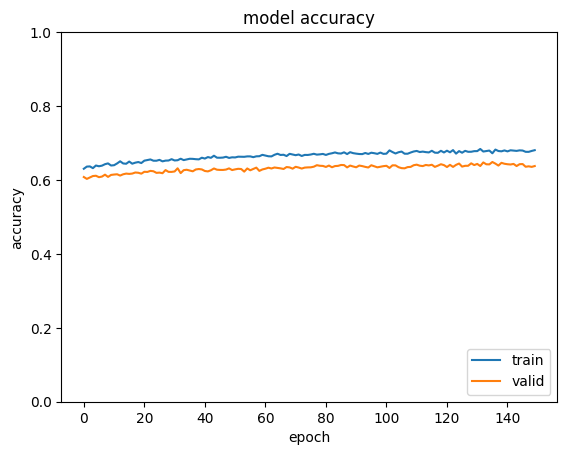

1.5542806890275744
1.687602870517307


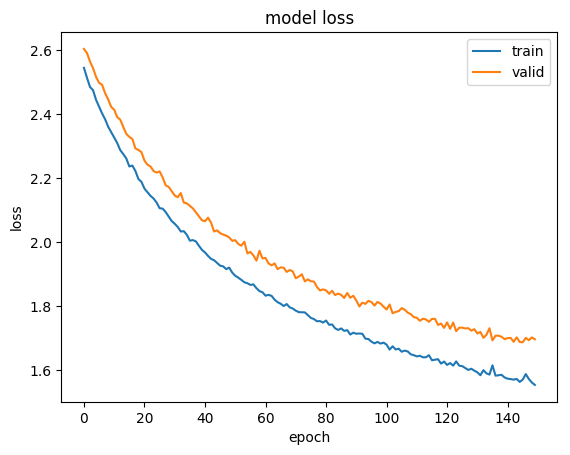

In [170]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim(0, 1)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
print(min(history.history['loss']))
print(min(history.history['val_loss']))
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

In [171]:
# 40 pred and then mean and argmax for the val set
SET=x_val
pred=np.zeros((len(SET),1))
for i in tqdm(range(0,len(SET))):
  multi_img=np.tile(SET[i],(40,1,1,1))
  preds=model.predict(multi_img)
  pred[i]=np.argmax(np.mean(preds,axis=0))#mean over n runs of every proba class

In [0]:
pred_mean_label=np.array([labels_no_horse[np.int(pred[i])] for i in range(0,len(pred))])
true_label=np.array([labels_no_horse[np.int(np.argmax(y_val[i]))] for i in range(0,len(y_val))])

In [173]:
print("val_acc =" ,np.sum(pred_mean_label==true_label)/len(true_label))
#better acc than it seems when you look at val acc from the fit output (around 64%)

val_acc = 0.6903333333333334


In [174]:
# 100 pred and then mean and argmax for the test set
SET=x_test
pred=np.zeros((len(SET),1))
for i in tqdm(range(0,len(SET))):
  multi_img=np.tile(SET[i],(40,1,1,1))
  preds=model.predict(multi_img)
  pred[i]=np.argmax(np.mean(preds,axis=0))
#kann maximal 90% sein  

In [175]:
print(np.sum(y_test==7))
len(y_test)
#horses in the test dataset
#max possible acc = 90&

1000


10000

In [0]:
pred_mean_label=np.array([labels_no_horse[np.int(pred[i])] for i in range(0,len(pred))])
true_label=np.array([labels[np.int(y_test[i])] for i in range(0,len(y_test))])

In [177]:
print("test_acc =" ,np.sum(pred_mean_label==true_label)/len(true_label))
#test acc 

test_acc = 0.6215


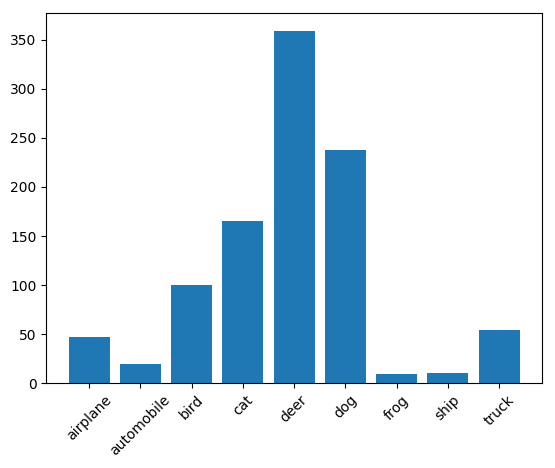

In [178]:
horse_idx=np.where(true_label=="horse")
plt.bar(np.unique(pred_mean_label[horse_idx],return_counts=True)[0],np.unique(pred_mean_label[horse_idx],return_counts=True)[1])
plt.xticks(rotation=45)
plt.show()
# horse gets mostly predicted as deer,dog cat,as bird or even truck 

In [179]:

## look at the means sd and entropy of the true horses of the testset,
## here we want to see a hight uncertainty

# 100 pred and then mean and argmax for the test set
SET=x_test[np.where(y_test==7)[0]]

pred=np.zeros((len(SET),1))
pred_std_uk=np.zeros((len(SET),1))
pred_means_uk=np.zeros((len(SET),9))
entropy_uk = np.zeros((len(SET),1))

for i in tqdm(range(0,len(SET))):
  multi_img=np.tile(SET[i],(40,1,1,1))
  preds=model.predict(multi_img)
  pred_means_uk[i]= np.mean(preds,axis=0)
  pred[i]=np.argmax(np.mean(preds,axis=0))
  pred_std_uk[i]= np.sqrt(np.sum(np.var(preds, axis=0)))
  entropy_uk[i] = -np.sum( pred_means_uk[i] * np.log2(pred_means_uk[i] + 1E-14)) #Numerical Stability


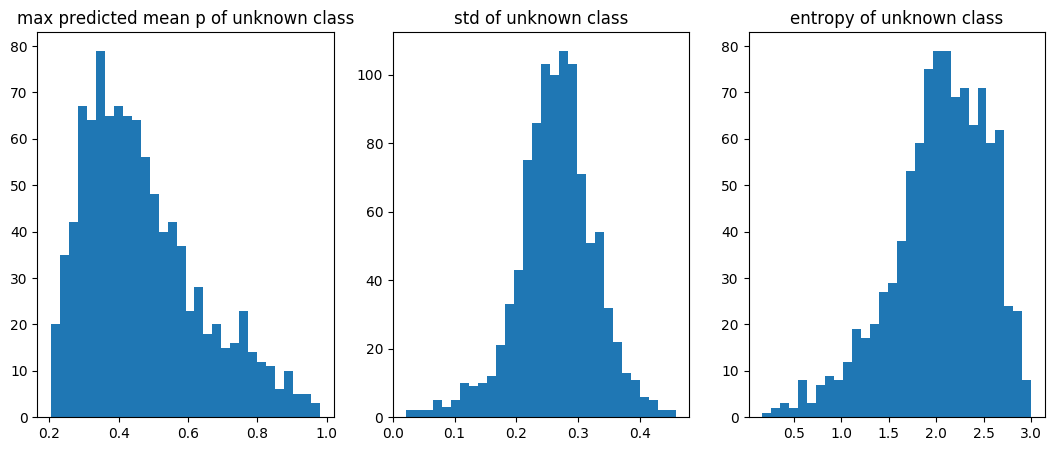

In [180]:
plt.figure(figsize=(13,5))
plt.subplot(1,3,1)
plt.hist(np.max(pred_means_uk,axis=1),bins=30)
plt.title("max predicted mean p of unknown class")
plt.subplot(1,3,2)
plt.hist(pred_std_uk,bins=30)
plt.title("std of unknown class")
plt.subplot(1,3,3)
plt.hist(entropy_uk,bins=30)
plt.title("entropy of unknown class")
plt.show()


In [181]:

## look at the means sd and entropy of all classes except the horses,
## here we want to see a low uncertainty

# 100 pred and then mean and argmax for the test set
SET=x_test[np.where(y_test!=7)[0]]

pred=np.zeros((len(SET),1))
pred_std_k=np.zeros((len(SET),1))
pred_means_k=np.zeros((len(SET),9))
entropy_k = np.zeros((len(SET),1))

for i in tqdm(range(0,len(SET))):
  multi_img=np.tile(SET[i],(40,1,1,1))
  preds=model.predict(multi_img)
  pred_means_k[i]= np.mean(preds,axis=0)
  pred[i]=np.argmax(np.mean(preds,axis=0))
  pred_std_k[i]= np.sqrt(np.sum(np.var(preds, axis=0)))
  entropy_k[i] = -np.sum( pred_means_k[i] * np.log2(pred_means_k[i] + 1E-14)) #Numerical Stability


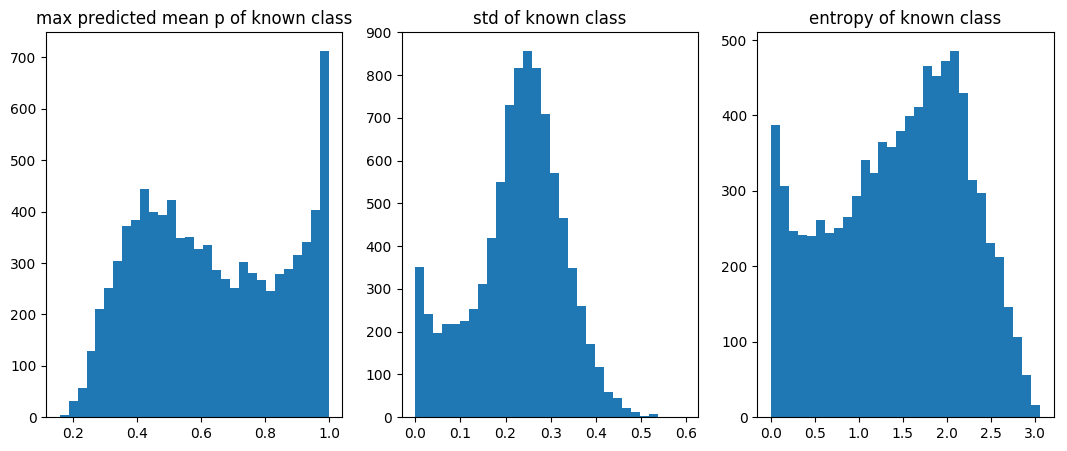

In [182]:
plt.figure(figsize=(13,5))
plt.subplot(1,3,1)
plt.hist(np.max(pred_means_k,axis=1),bins=30)
plt.title("max predicted mean p of known class")
plt.subplot(1,3,2)
plt.hist(pred_std_k,bins=30)
plt.title("std of known class")
plt.subplot(1,3,3)
plt.hist(entropy_k,bins=30)
plt.title("entropy of known class")
plt.show()

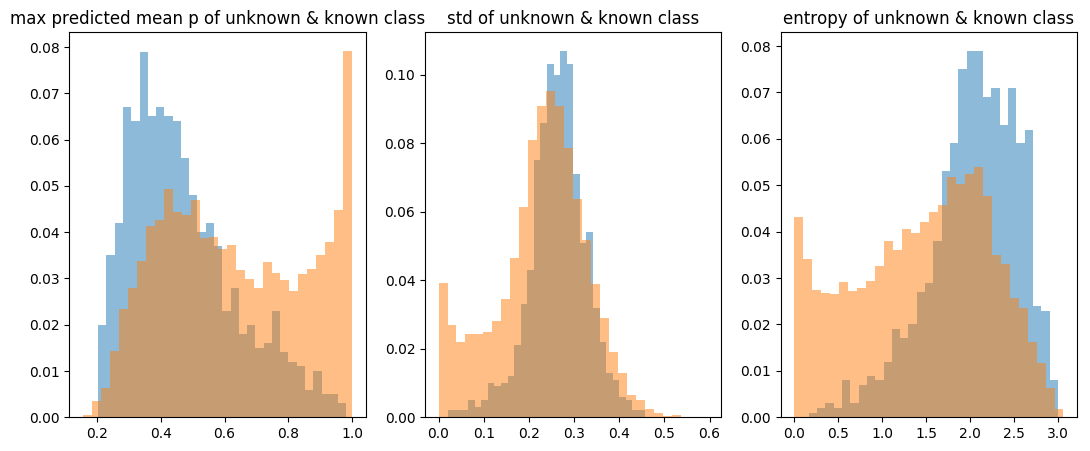

In [183]:
plt.figure(figsize=(13,5))
plt.subplot(1,3,1)
plt.hist(np.max(pred_means_uk,axis=1),bins=30, weights=np.repeat(1 / len(pred_means_uk),len(pred_means_uk)),alpha=0.5)
plt.hist(np.max(pred_means_k,axis=1),bins=30,weights=np.repeat(1 / len(pred_means_k),len(pred_means_k)),alpha=0.5)
plt.title("max predicted mean p of unknown & known class")
plt.subplot(1,3,2)
plt.hist(pred_std_uk,bins=30,weights=np.repeat(1 / len(pred_std_uk),len(pred_std_uk)),alpha=0.5)
plt.hist(pred_std_k,bins=30,weights=np.repeat(1 / len(pred_std_k),len(pred_std_k)),alpha=0.5)
plt.title("std of unknown & known class")
plt.subplot(1,3,3)
plt.hist(entropy_uk,bins=30,weights=np.repeat(1 / len(entropy_uk),len(entropy_uk)),alpha=0.5)
plt.hist(entropy_k,bins=30,weights=np.repeat(1 / len(entropy_k),len(entropy_k)),alpha=0.5)
plt.title("entropy of unknown & known class")
plt.show()


## no VI

In [192]:
model2 = tf.keras.Sequential()
model2.add(tf.keras.layers.Convolution2D(8,kernel_size=(3,3),padding="same", activation = 'relu', input_shape=(32,32,3)))
#model.add(tf.keras.layers.Dropout((0.3)))
model2.add(tf.keras.layers.Convolution2D(8,kernel_size=(3,3),padding="same", activation = 'relu'))
#model.add(tf.keras.layers.Dropout((0.3)))
model2.add(tf.keras.layers.MaxPooling2D((2,2)))
model2.add(tf.keras.layers.Convolution2D(16,kernel_size=(3,3),padding="same", activation = 'relu'))
#model.add(tf.keras.layers.Dropout((0.3)))
model2.add(tf.keras.layers.Convolution2D(16,kernel_size=(3,3),padding="same", activation = 'relu'))
#model.add(tf.keras.layers.Dropout((0.3)))
model2.add(tf.keras.layers.MaxPooling2D((2,2)))
model2.add(tf.keras.layers.Convolution2D(32,kernel_size=(3,3),padding="same", activation = 'relu'))
#model.add(tf.keras.layers.Dropout((0.3)))
model2.add(tf.keras.layers.Convolution2D(32,kernel_size=(3,3),padding="same", activation = 'relu'))
#model.add(tf.keras.layers.Dropout((0.3)))
model2.add(tf.keras.layers.MaxPooling2D((2,2)))
model2.add(tf.keras.layers.Flatten())
model2.add(tf.keras.layers.Dense(100, activation = 'relu'))
model2.add(tf.keras.layers.Dropout((0.5)))
model2.add(tf.keras.layers.Dense(9, activation = 'softmax'))

model2.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

model2.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 32, 32, 8)         224       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 32, 32, 8)         584       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 16, 16, 16)        1168      
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 16, 16, 16)        2320      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 8, 8, 16)          0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 8, 8, 32)         

In [193]:
history=model2.fit(x_train, y_train,validation_data=(x_val,y_val), batch_size=128,epochs=50,verbose=1)


Train on 27000 samples, validate on 18000 samples
Epoch 1/50
27000/27000 [==============================] - 3s 128us/sample - loss: 1.8121 - accuracy: 0.2909 - val_loss: 1.5089 - val_accuracy: 0.4208
Epoch 2/50
27000/27000 [==============================] - 3s 106us/sample - loss: 1.5280 - accuracy: 0.4109 - val_loss: 1.4481 - val_accuracy: 0.4455
Epoch 3/50
27000/27000 [==============================] - 3s 109us/sample - loss: 1.4282 - accuracy: 0.4571 - val_loss: 1.3453 - val_accuracy: 0.4923
Epoch 4/50
27000/27000 [==============================] - 3s 106us/sample - loss: 1.3488 - accuracy: 0.4931 - val_loss: 1.2442 - val_accuracy: 0.5362
Epoch 5/50
27000/27000 [==============================] - 3s 108us/sample - loss: 1.2881 - accuracy: 0.5170 - val_loss: 1.1828 - val_accuracy: 0.5548
Epoch 6/50
27000/27000 [==============================] - 3s 106us/sample - loss: 1.2382 - accuracy: 0.5363 - val_loss: 1.1510 - val_accuracy: 0.5737
Epoch 7/50
27000/27000 [==========================

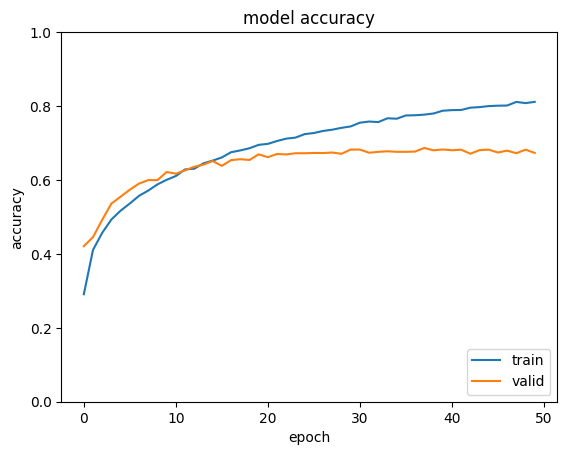

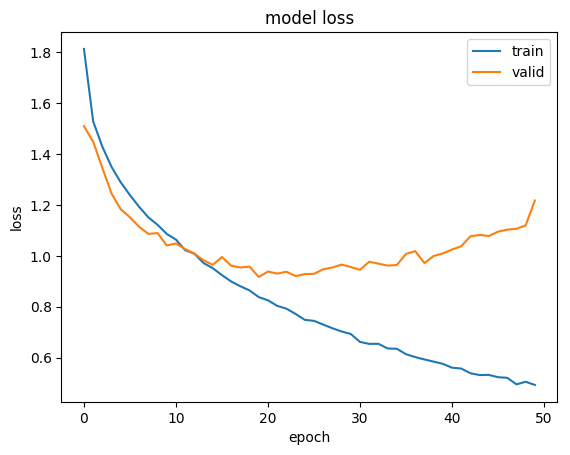

In [194]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim(0, 1)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

In [222]:
pred=np.argmax(model2.predict(x_val),axis=1)
pred_label=np.array([labels_no_horse[np.int(pred[i])] for i in range(0,len(pred))])
true_label=np.array([labels_no_horse[np.int(np.argmax(y_val[i]))] for i in range(0,len(y_val))])
print("val_acc =" ,np.sum(pred_label==true_label)/len(true_label))

val_acc = 0.6731666666666667


In [229]:
pred=np.argmax(model2.predict(x_test),axis=1)
pred_label=np.array([labels_no_horse[np.int(pred[i])] for i in range(0,len(pred))])
true_label=np.array([labels[np.int(y_test[i])] for i in range(0,len(y_test))])
print("test_acc =" ,np.sum(pred_label==true_label)/len(true_label))

test_acc = 0.6035


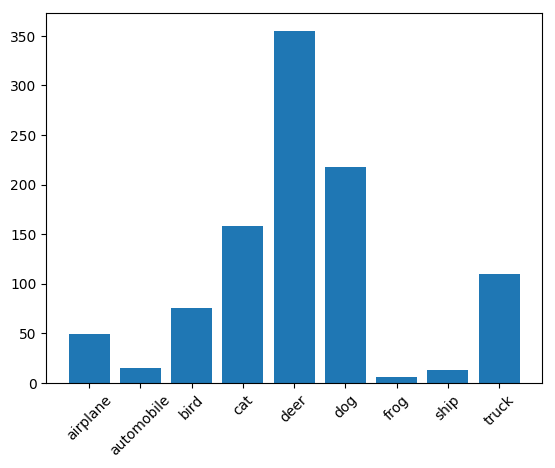

In [230]:
horse_idx=np.where(true_label=="horse")
plt.bar(np.unique(pred_label[horse_idx],return_counts=True)[0],np.unique(pred_label[horse_idx],return_counts=True)[1])
plt.xticks(rotation=45)
plt.show()
# horse gets mostly predicted as deer,dog cat,as bird or even truck 

Text(0.5, 1.0, 'max p of unknown class')

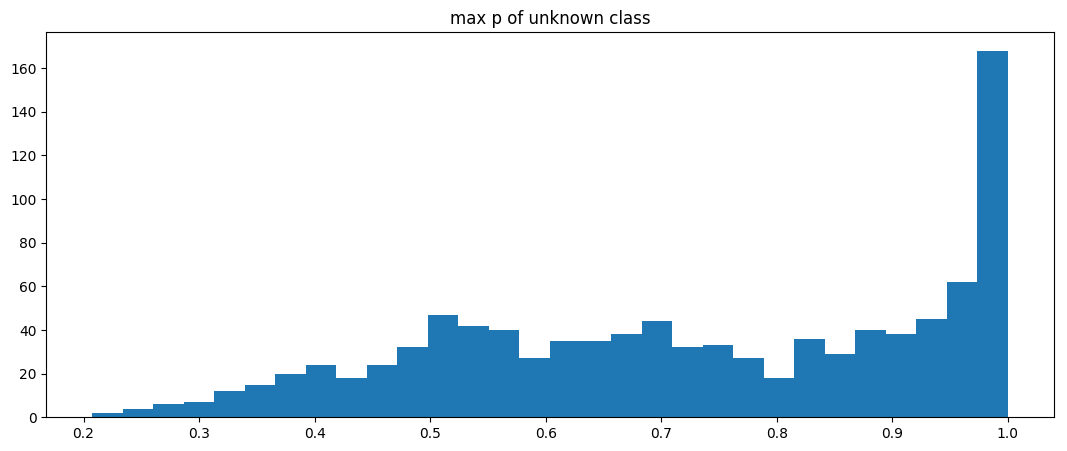

In [267]:

## look at the means sd and entropy of the true horses of the testset,
## here we want to see a hight uncertainty

SET=x_test[np.where(y_test==7)[0]]
preds=model2.predict(SET)  
max_p_uk=np.array([preds[i,np.argmax(preds,axis=1)[i]] for i in range(0,len(preds))])
plt.figure(figsize=(13,5))
#plt.subplot(1,3,1)
plt.hist(max_p_uk,bins=30)
plt.title("max p of unknown class")

Text(0.5, 1.0, 'max p of known class')

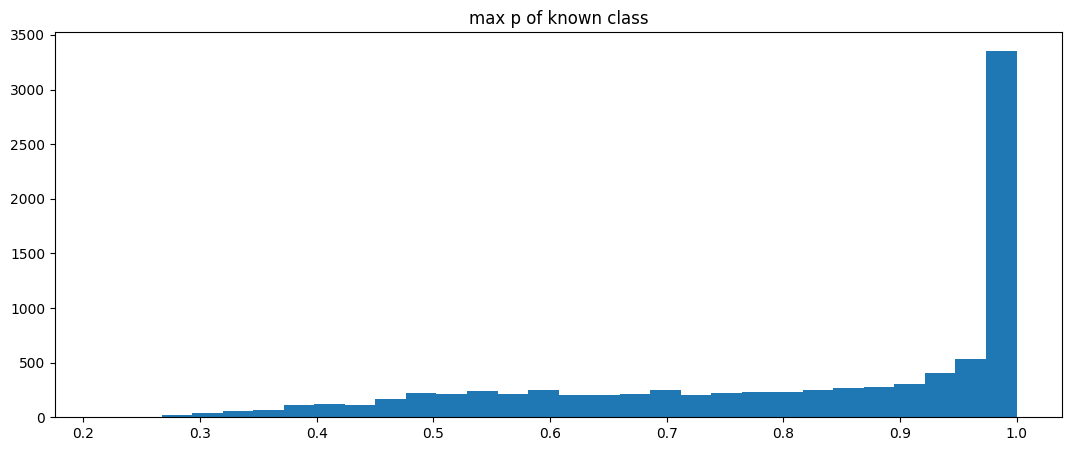

In [268]:

## look at the means sd and entropy of the true horses of the testset,
## here we want to see a hight uncertainty

SET=x_test[np.where(y_test!=7)[0]]
preds=model2.predict(SET)  
max_p_k=np.array([preds[i,np.argmax(preds,axis=1)[i]] for i in range(0,len(preds))])
plt.figure(figsize=(13,5))
plt.hist(max_p_k,bins=30)
plt.title("max p of known class")

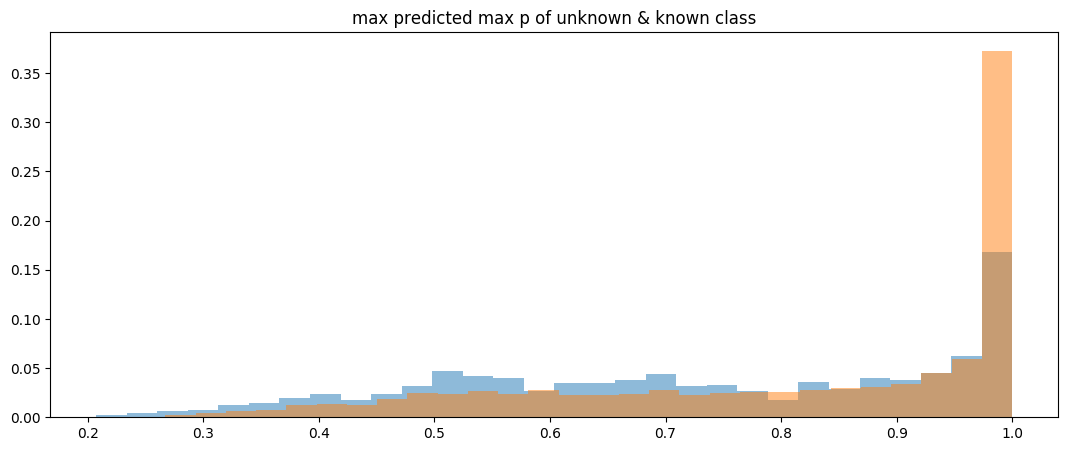

In [271]:
plt.figure(figsize=(13,5))
plt.hist(max_p_uk,bins=30, weights=np.repeat(1 / len(max_p_uk),len(max_p_uk)),alpha=0.5)
plt.hist(max_p_k,bins=30,weights=np.repeat(1 / len(max_p_k),len(max_p_k)),alpha=0.5)
plt.title("max predicted max p of unknown & known class")
plt.show()
